#  Original Script in: https://github.com/JackS9/jupyter-scipy-geo-notebook
# Analysis and display of water quality indicators along Kanawha River, West Virginia
# == Water Quality Data source available in: https://doi.org/10.6084/m9.figshare.9786212
# == Full credits to cite:== Huber, David H; Ugwuanyi, Ifeoma R.; Lhilhi Noundou, Vadesse; Kemajou Tchamba, Andrielle L.;  Chavarria-Palma, Jesus Emmanuel (2019): Water Quality for Kanawha River WV. figshare. Dataset.

<h3>Quick index:</h3>
<ul>
    <li><a href=#map>Map</a></li>
    <li><a href=#transect_plots>Transect Plots</a></li>
    <li><a href=#transect_3d_profiles>Transect 3D Profiles</a></li>
    <li><a href=#ironton_usgs_plots>USGS Gage at Ironton</a></li>
    <li><a href=#locks_plots>Sonde data at RCBI and Greenup Locks</a></li>    </ul>

#### TODO:
* Do timeseries data first, then transects using dynamically generated 2D (RMI x 6H-means) baseline data from Locks
* **NWS** (weather) data
* **WQP** data
* WV DEP data (**TAGIS**)
* Other SENSE/AFI data 
* Plots in **marker popups**
* More **consistent naming** of input/output files, functions, plot labels,...
* Put all local data in a **database** and access from there

## == Get things set up ==

### To install packages locally (e.g., folium, geopandas, fiona, shapely):
```
%%bash -l
use -e -r anaconda3-5.1
pip install folium --prefix=. --upgrade-strategy only-if-needed
```

#### To access them:
```
import os, sys
sys.path.insert(0,'lib/python3.7/site-packages') # Add locally installed packages to path
```

### Use full width of browser window

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
#IFrame(HTML("<style>.container { width:100% !important; height:100% !important}</style>"))

### Enable R-style DataFrames with Pandas, numerical arrays and matrices with NumPy

In [2]:
import pandas as pd
import numpy as np

### Enable Math functions

In [3]:
import math

### Enable working with Dates and Times

In [4]:
import time

### Enable Pandas scatter plot matrices

In [5]:
from pandas.plotting import scatter_matrix

### Enable inline MATLAB-style plotting with MatPlotLib

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

### Enable 3D plotting in MatPlotLib using MPlot3D toolkit

In [7]:
from mpl_toolkits.mplot3d import Axes3D

### Enable interactive plots using iPyWidgets

In [8]:
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual

### Enable geospatial DataFrames with GeoPandas (built on Fiona, which is built on GDAL/OGR)

In [9]:
import os
import geopandas as gpd

### Enable Leatlet.JS-based mapping with Folium 

In [10]:
import folium
from folium import IFrame
import folium.plugins as plugins

### Enable additional HTML features with Branca

In [11]:
import branca

### Enable other geospatial utilities with Shapely

In [12]:
import shapely
from shapely.geometry import Point
import webbrowser
import pingouin as pg
import seaborn as sns

# == Sampling Sites ==

### Get all sampling sites along Kanawha River
#### TO DO:
 * Add CSO positions

In [13]:
kanawha_river_sites = pd.read_csv('Kanawha/kanawha_river_sites2.csv')
site_geometries = gpd.GeoSeries(kanawha_river_sites.apply(lambda z: Point(z['Longitude'],z['Latitude']),1),crs={'init':'epsg:4326'})
kanawha_river_sites = gpd.GeoDataFrame(kanawha_river_sites.drop(['Latitude','Longitude'],1),geometry=site_geometries)
#kanawha_river_sites

### Generate map of all sampling sites

In [14]:
kanawha_map = folium.Map([38.24, -81.36],zoom_start=10,tiles=None)

#### TODO: 
 * Look into **branca.element.IFrame** to preprocess HTML into IFrame -- construct a graph!
 * User Folium **MarkerCluster** and **FeatureGroup** to reduce number of markers (on Zoom out) and turn on/off different marker layers
 * Look at folium.plugins **HeatMap** and **HeatMapWithTime** -- only good for density, not property values!

In [15]:
 for i, row in kanawha_river_sites.iterrows():
    coord = [row.geometry.y,row.geometry.x]
    label = row.Type#+' @ '+row.Name
    marker_type = 'pin'
    radius = 1
    color = 'red'
    # Available colors: red, darkred, lightred, pink, green, darkgreen, lightgreen, blue, darkblue, lightblue, cadetblue, purple, darkpurple, orange, beige, black, gray, lightgray
    icon = 'dashboard'
    html = label
    width = 500
    height = 90
    max_width = 1000
    nav_params = '?distance=100'
    if (row.Type == 'Transect'):
        color = 'beige'
        html += '<br>'+row.Description
    elif (row.Type == 'USGS Gage'):
        if (row.Name == 'Kanawha Falls'):
            nwis_site_json = gpd.read_file("https://cida.usgs.gov/nldi/nwissite/USGS-0{0:.0f}".format(row['USGS Code']))
            comid = nwis_site_json.comid[0]
            comid_url = "https://cida.usgs.gov/nldi/comid/"+comid
            #folium.GeoJson(nwis_site_json,name="NLDI USGS Gage",show=False).add_to(kanawha_map)
            folium.GeoJson(comid_url+"/basin",name="Drainage Basin for USGS-0{0:.0f}".format(row['USGS Code']),show=False).add_to(kanawha_map)
            folium.GeoJson(comid_url+"/navigate/UM",name="Upstream Main",show=False).add_to(kanawha_map)
            folium.GeoJson(comid_url+"/navigate/UT"+nav_params,name="Tributaries Upstream",show=False).add_to(kanawha_map)
            folium.GeoJson(comid_url+"/navigate/UM/nwissite"+nav_params,name="NWIS Sites Upstream Main",show=False).add_to(kanawha_map)
            folium.GeoJson(comid_url+"/navigate/UM/huc12pp"+nav_params,name="HUC12 Pour Points Upstream Main",show=False).add_to(kanawha_map)
            folium.GeoJson(comid_url+"/navigate/UM/wqp"+nav_params,name="WQP Stations Upstream Main",show=False).add_to(kanawha_map)
            folium.GeoJson(comid_url+"/navigate/DM",name="Downstream Main",show=False).add_to(kanawha_map)
            folium.GeoJson(comid_url+"/navigate/DD"+nav_params,name="Downstream Diversions",show=False).add_to(kanawha_map)
            folium.GeoJson(comid_url+"/navigate/DM/nwissite"+nav_params,name="NWIS Sites Downstream Main",show=False).add_to(kanawha_map)
            folium.GeoJson(comid_url+"/navigate/DM/huc12pp"+nav_params,name="HUC12 Pour Points Downstream Main",show=False).add_to(kanawha_map)
            folium.GeoJson(comid_url+"/navigate/DM/wqp"+nav_params,name="WQP Stations Downstream Main",show=False).add_to(kanawha_map)
        if (row.Name == 'Charleston'):
            nwis_site_url = "https://cida.usgs.gov/nldi/nwissite/USGS-0{0:.0f}".format(row['USGS Code'])
            nwis_site_json = gpd.read_file(nwis_site_url)
            folium.GeoJson(nwis_site_url+"/basin",name="Drainage Basin for USGS-0{0:.0f}".format(row['USGS Code']),show=False).add_to(kanawha_map)
            folium.GeoJson(nwis_site_url+"/navigate/UT/huc12pp"+nav_params,name="HUC12 Pour Points Upstream Tributaries",show=False).add_to(kanawha_map)
            folium.GeoJson(nwis_site_url+"/navigate/UT/wqp"+nav_params,name="WQP Stations Upstream Tributaries",show=False).add_to(kanawha_map)
        marker_type = 'circle'
        radius = 8
        color = 'green'
        fill = True
        fill_color = color
        html += '<br><a href=\"https://waterdata.usgs.gov/monitoring-location/0{0:.0f}'.format(row['USGS Code'])+'\",target=\"_blank\">Site info for USGS Gage: 0{0:.0f}'.format(row['USGS Code'])+'</a>'
        html += '<br><a href=\"https://waterdata.usgs.gov/nwis/uv?site_no=0{0:.0f}'.format(row['USGS Code'])+'\",target=\"_blank\">Data for USGS Gage: 0{0:.0f}'.format(row['USGS Code'])+'</a>'
        width = 1000
        height = 500
    elif (row.Type == 'Locks and Dam'):
        marker_type = 'circle'
        radius = 8
        color = 'black'
        fill = True
        fill_color = color
        html += '<br><a href=\"http://www.lrh-wc.usace.army.mil/wm/?river/kanawha'+'\",target=\"_blank\">Data access to river: {0:s}'.format(row['USACE Code'])+'</a>' 
        width = 1000
        height = 500
    elif (row.Type == 'Sonde Data'):
        marker_type = 'circle'
        radius = 10
        color = 'red'
        fill = True
        fill_color = color
        html += '<br>'+row.Description
        width = 1000
        height = 500
    else:
        continue
    html += '<br>Lat: {0:.2f}'.format(row.geometry.y)+', Lon: {0:.2f}'.format(row.geometry.x)
  #  html += '<br>RMI: {0:.1f}'.format(row.RMI)
    iframe = folium.IFrame(html,width=width,height=height)
    popup = folium.Popup(iframe,max_width=max_width)
    if (marker_type == 'pin'):
        folium.Marker(location=coord,icon=folium.Icon(color=color,icon=icon),popup=popup,tooltip=label).add_to(kanawha_map)
    elif (marker_type == 'circle'):
        folium.CircleMarker(location=coord,radius=radius,color=color,popup=popup,tooltip=label).add_to(kanawha_map)
    else:
        continue

#### Add the builtin OpenStreetMap and Stamen Terrain basemaps

In [16]:
folium.TileLayer('OpenStreetMap').add_to(kanawha_map)
folium.TileLayer('StamenTerrain').add_to(kanawha_map)

#### Add other basemap options using Map Servers at  ArcGIS Online

In [17]:
mapserver_query = '/MapServer/tile/{z}/{y}/{x}'
ESRI = dict(NatGeo_World_Map='http://services.arcgisonline.com/arcgis/rest/services/NatGeo_World_Map/MapServer',
            World_Imagery='http://services.arcgisonline.com/arcgis/rest/services/World_Imagery/MapServer',
            World_Shaded_Relief='http://services.arcgisonline.com/arcgis/rest/services/World_Shaded_Relief/MapServer',
            World_Street_Map='http://services.arcgisonline.com/arcgis/rest/services/World_Street_Map/MapServer',
            World_Topo_Map='http://services.arcgisonline.com/arcgis/rest/services/World_Topo_Map/MapServer',
            World_Hydro_Reference='http://hydrology.esri.com/arcgis/rest/services/WorldHydroReferenceOverlay/MapServer')

for tile_name, tile_url in ESRI.items():
    tile_url += mapserver_query
    folium.TileLayer(tile_url,name=tile_name,attr=tile_name).add_to(kanawha_map)

#### Add HUC boundaries 
 * First example converts a HUC10 .shp file to GeoJSON
 * Second example streams GeoJSON from the USGS National Map (NHDPlus) HUC12 Web Service using bounding box (envelope)

In [18]:
#folium.GeoJson("https://hydro.nationalmap.gov/arcgis/rest/services/NHDPlus_HR/MapServer/11/query?where=&text=&objectIds=&time=&geometry=-83%2C38.4%2C-82%2C38.7&geometryType=esriGeometryEnvelope&inSR=&spatialRel=esriSpatialRelIntersects&relationParam=&outFields=&returnGeometry=true&returnTrueCurves=false&maxAllowableOffset=&geometryPrecision=&outSR=&having=&returnIdsOnly=false&returnCountOnly=false&orderByFields=&groupByFieldsForStatistics=&outStatistics=&returnZ=false&returnM=false&gdbVersion=&historicMoment=&returnDistinctValues=false&resultOffset=&resultRecordCount=&queryByDistance=&returnExtentOnly=false&datumTransformation=&parameterValues=&rangeValues=&quantizationParameters=&f=geojson",show=False,name='HUC12 Boundararies').add_to(kanawha_map)

#### Add Streams 
 * Why do only certain segments appear?

In [19]:
#folium.GeoJson("https://hydro.nationalmap.gov/arcgis/rest/services/NHDPlus_HR/MapServer/2/query?where=FTYPE%3D460&text=&objectIds=&time=&geometry=-83%2C38.4%2C-82%2C38.7&geometryType=esriGeometryEnvelope&inSR=&spatialRel=esriSpatialRelIntersects&relationParam=&outFields=&returnGeometry=true&returnTrueCurves=false&maxAllowableOffset=&geometryPrecision=&outSR=&having=&returnIdsOnly=false&returnCountOnly=false&orderByFields=&groupByFieldsForStatistics=&outStatistics=&returnZ=false&returnM=false&gdbVersion=&historicMoment=&returnDistinctValues=false&resultOffset=&resultRecordCount=&queryByDistance=&returnExtentOnly=false&datumTransformation=&parameterValues=&rangeValues=&quantizationParameters=&f=geojson",show=False,name='Streams').add_to(kanawha_map)

#### Add raster (image) overlayers of the Study Area
 * Shapefile of three drainage areas
 
#### TODO:
 * Tiles of drainage areas
 * Delimiting drainage area based on location of USGS flow gages
 * Location of weather stations
 

In [20]:

gdf = gpd.GeoDataFrame.from_file("Kanawha/StudyArea.shx")
folium.GeoJson(gdf, name="Three Drainage Areas", show=True).add_to(kanawha_map) ## Specs of 1, 2 & 3 Drainage sections
folium.Marker(['38.1','-81.3'], popup='Drainage Section 1', icon = folium.Icon(color='darkblue')).add_to(kanawha_map)
folium.Marker(['38.36','-81.4'], popup='Drainage Section 2', icon = folium.Icon(color='darkblue')).add_to(kanawha_map)
folium.Marker(['38.45','-81.7'], popup='Drainage Section 3', icon = folium.Icon(color='darkblue')).add_to(kanawha_map)
###USGS FLOW GAGES
folium.Marker(['38.1381','-81.2144'], popup='Kanawha Falls \nUSGS Flow Gage', icon = folium.Icon(color='blue')).add_to(kanawha_map)
folium.Marker(['38.4708','-81.2842'], popup='Elk River at Queen Shoals \nUSGS Flow Gage', icon = folium.Icon(color='blue')).add_to(kanawha_map)
folium.Marker(['38.3714','-81.7022'], popup='Charleston \nUSGS Flow Gage', icon = folium.Icon(color='blue')).add_to(kanawha_map)
folium.Marker(['38.3389','-81.8417'], popup='Coal River \nUSGS Flow Gage', icon = folium.Icon(color='blue')).add_to(kanawha_map)
folium.Marker(['38.5261','-81.6314'], popup='Pocatalico River \nUSGS Flow Gage', icon = folium.Icon(color='blue')).add_to(kanawha_map)
###CLIMATE STATIONS
folium.Marker(['38.3794','-81.5900'], popup='Charleston Yeager Airport \nUSGS Flow Gage', icon = folium.Icon(color='orange')).add_to(kanawha_map)
folium.Marker(['38.3131','-81.7192'], popup='National Weather Service South Charleston \nUSGS Flow Gage', icon = folium.Icon(color='orange')).add_to(kanawha_map)

#### Add the Layer Control widget

In [21]:
folium.LayerControl().add_to(kanawha_map)

#### Save the map as HTML and display it
 * Suppress before publishing as read-only Tool

<div id='map' />

## Map

In [22]:
kanawha_map.save('kanawha_map.html')

In [23]:
from IPython.display import IFrame
IFrame("kanawha_map.html", width=1000, height=500)

## == Transects ==
## == Water Quality Data source available in: https://doi.org/10.6084/m9.figshare.9786212

### Read in CSV-formatted table of geo-tagged and time-stamped sensor data from the transects into a DataFrame

#### Get Sonde data

In [24]:
transects_sonde = pd.read_csv('Kanawha/transects_sonde2.csv',encoding='latin1')

#### Get PAR data (Transects PAR data excluded for Kanawha River)

In [25]:
#transects_par = pd.read_csv('data/Greenup/transects_par.csv',encoding='latin1')

#### Parse out Horizontal and Vertical position codes along transect 

In [26]:
transects_sonde['H Code'] = transects_sonde['Site Name'].apply(lambda x: x[0])
transects_sonde['V Code'] = transects_sonde['Site Name'].apply(lambda x: x[1:])

In [27]:
#transects_par['H Code'] = transects_par['SITE'].apply(lambda x: x[0])
#transects_par['V Code'] = transects_par['SITE'].apply(lambda x: x[1:])

#### Create Data-Time field from Date and Time fields

In [28]:
def datetime_sonde(row):
    pattern = '%m/%d/%Y-%H:%M:%S'
    dt = row['Date (MM/DD/YYYY)']+'-'+row['Time (HH:MM:SS)']
    return pd.to_datetime(time.mktime(time.strptime(dt,pattern)),unit='s')
    
transects_sonde['Date-Time'] = transects_sonde.apply(lambda row: datetime_sonde(row),axis=1)

In [29]:
#def datetime_par(row):
#    pattern = '%m/%d/%Y-%I:%M:%S %p'
#    dt = row['Date']+'-'+row['Time']
#    return pd.to_datetime(time.mktime(time.strptime(dt,pattern)),unit='s')
    
#transects_par['Date-Time_par'] = transects_par.apply(lambda row: datetime_par(row),axis=1)

#### Filter out Test samples from Sonde data 
 * TO DO: Consider dropping in place

In [30]:
transects_sonde = transects_sonde[transects_sonde['Site Name'].str.contains('Test')==False]

#### Convert Transect and Horizontal positions to numbers (for plotting profiles)

In [31]:
transects_sonde['T Pos'] = transects_sonde['Transect'].apply(lambda x: int(x[2:]))
transects_sonde['H Pos'] = transects_sonde['H Code'].apply(lambda x: int(x))

In [32]:
#transects_par['T Pos'] = transects_par['Transect'].apply(lambda x: int(x[2:]))
#transects_par['H Pos'] = transects_par['H Code'].apply(lambda x: int(x))

#### Filter out non-data, empty columns (like TSS), and reduntant columns (like chlorophyll, BGA, conductivity, pH, and depth)

In [33]:
transects_sonde_dataonly = transects_sonde.drop(transects_sonde.columns[:8],axis=1) \
    .drop(transects_sonde.columns[[10,11,12]],axis=1) \
    .drop(transects_sonde.columns[[13,15,16]],axis=1) \
    .drop(transects_sonde.columns[[17,18,19]],axis=1) \
    .drop(transects_sonde.columns[[20,21,23]],axis=1) \
    .drop(transects_sonde.columns[[25]],axis=1)

In [34]:
#transects_par_dataonly = transects_par.drop(transects_par.columns[:3],axis=1).drop(['H Code','BATT','SITE','CHK','Date-Time_par'],axis=1) \
#    .drop(['PAR_MAX','PAR_MIN'],axis=1)

#### Create 3-part Index from T, H, and V values to help join Sonde and PAR(Excluded) data 
 * Only keep one set of original columns (Sonde)

In [35]:
transects_sonde_dataonly = transects_sonde_dataonly.set_index(['T Pos','H Pos','V Code'],drop=False)

In [36]:
#transects_par_dataonly = transects_par_dataonly.set_index(['T Pos','H Pos','V Code'],drop=True)

#### Combine/Rename (merge/join) Sonde data 
 * Get rid of 'V Code' column, which is no longer needed

In [37]:
transects_sonde_par = transects_sonde_dataonly

#### Create column for Chlorophyll / BGA ratio (No needed for Kanawha River, WV)
 * Fix ranges first to keep numerator positive and denominator > zero

In [38]:
#transects_sonde_par['Chlorophyll µg/L'] = transects_sonde_par['Chlorophyll µg/L'].apply(lambda x: 0.0 if x < 0.0 else x)

In [39]:
#transects_sonde_par['BGA-PC µg/L'] = transects_sonde_par['BGA-PC µg/L'].apply(lambda x: 0.1 if x < 0.1 else x)

In [40]:
#transects_sonde_par['Chlorophyll/BGA'] = transects_sonde_par.apply(lambda x: x['Chlorophyll µg/L']/x['BGA-PC µg/L'], axis=1)
#transects_sonde_par.head()

#### Merge in location data, including RMI (No needed for Kanawha River, WV)
 * Create temporary matching Name column (from 'T Pos') for merging
 * Drop all unnecessary columns

In [41]:
# transects_sonde_par['Name'] = transects_sonde_par['T Pos'].apply(lambda x: 'T-'+str(x))
# transects_sonde_par = pd.merge(transects_sonde_par,kanawha_river_sites,on=['Name']).drop(kanawha_river_sites.columns[0:5],axis=1).drop(kanawha_river_sites.columns[6:],axis=1)
#transects_sonde_par.columns

#### Re-index by datetime

In [42]:
transects_sonde_par = transects_sonde_par.set_index(['Date-Time'])
#transects_sonde_par.columns

<div id='transect_plots'></div>

## Transect Plots (Kanawha River counts with 3 points of observation)
## == Water Quality Data source available in: https://doi.org/10.6084/m9.figshare.9786212


### Distribution plots of transect data

In [43]:
def dist_plot_transects(Property,Kind='kde'):
    transects_sonde_dataonly[Property].plot(kind=Kind)
    
interact(dist_plot_transects, \
         Property=transects_sonde_dataonly.columns.drop(['Date-Time','T Pos','H Pos', 'V Code','H Code']), \
         Kind=['hist','kde','box'] \
        )

interactive(children=(Dropdown(description='Property', options=('ODO % sat', 'ODO mg/L', 'Temp °C', 'pH', 'ORP…

<function __main__.dist_plot_transects(Property, Kind='kde')>

### Correlation Scatter Plots

#### Scatter matrix for all properties (disabled due to size)

In [44]:
#scatter_matrix(transects_sonde_par,figsize=(20.0,20.0),diagonal='kde')

#### Individual scatter plots (3rd property used for color map)

In [45]:
def scatter_plot_transects(YProperty=transects_sonde_par.columns[0],XProperty=transects_sonde_par.columns[1],CProperty=transects_sonde_par.columns[3],ColorMap='jet'):
    fig, ax = plt.subplots()
    transects_sonde_par.plot.scatter(ax=ax,x=XProperty,y=YProperty,c=CProperty,cmap=ColorMap,s=4)
    ax.set_title("Correlation of "+YProperty+" and "+XProperty,fontsize=14)
    
interact(scatter_plot_transects, \
         YProperty=transects_sonde_par.columns.drop(['T Pos','H Pos', 'V Code','H Code']), \
         XProperty=transects_sonde_par.columns.drop(['T Pos','H Pos', 'V Code','H Code']), \
         CProperty=transects_sonde_par.columns.drop(['T Pos','H Pos', 'V Code','H Code']), \
         ColorMap=['jet','viridis','magma','coolwarm','seismic','Greys','Reds','Blues'] \
        )

interactive(children=(Dropdown(description='YProperty', options=('ODO % sat', 'ODO mg/L', 'Temp °C', 'pH', 'OR…

<function __main__.scatter_plot_transects(YProperty='ODO % sat', XProperty='ODO mg/L', CProperty='pH', ColorMap='jet')>

### Use scatter plot to display depth x width profile for selected transect with data points colored by value of selected property (N/A for Kanawha River, WV)

In [46]:
# def transect_profile_plot(Transect,Property,ColorMap='jet'):
#     fig, ax = plt.subplots()
#     transect = transects_sonde_par[transects_sonde_par['T Pos']==Transect]
#     transect.plot.scatter(ax=ax,x='H Pos',y='Depth m',ylim=(15,0),c=Property,cmap=ColorMap,marker='H',s=250,xticks=[])
#     ax.set_title("Transect Profile for "+Property,fontsize=14)
#     ax.set(ylabel="Depth",xlabel="Cross-River Position")
    
# interact(transect_profile_plot, \
#          Transect=transects_sonde_par['T Pos'].unique(), \
#          Property=transects_sonde_par.columns.drop(['Depth m','T Pos','H Pos','PAR','RMI']), \
#          ColorMap=['jet','viridis','magma','coolwarm','seismic','Greys','Reds','Blues'] \
#         )

### Loop through all the data columns to create a profile panel (N/A for Kanawha River, WV)

In [47]:
# def transect_profile_panel(Transect,ColorMap='jet'):
#     fig, ax = plt.subplots(nrows=2,ncols=5,figsize=(25,10))
#     transect = transects_sonde_par
#     for col in transects_sonde_par.columns[:13].drop(['H Pos','H Pos', 'Depth m']):
#         #transect.plot.scatter(ax=ax[j,i],x='H Pos',y='Depth m',ylim=(14,0),c=col,cmap=ColorMap,marker='H',s=250)
#         ax[j,i].axis('off')
#         if i < 4:
#             i = i + 1
#         else:
#             i = 0
#             j = j + 1
            
# interact(transect_profile_panel, \
#          Transect=transects_sonde_par, \
#          ColorMap=['jet','viridis','magma','coolwarm','seismic','Greys','Reds','Blues'] \
#         )

### Get transect means and baseline values from corresponding measurements (N/A for Kanawha River, WV)
#### TO DO: Move to after base values determined from locks timeseries data

In [48]:
# transects_means_bases = pd.read_csv('data/Greenup/transects_with_bases.csv',encoding='latin1')

In [49]:
# transects_means_bases = transects_means_bases.drop(['ODO % sat_mean', 'ODO % sat_base', \
#     'Chlorophyll RFU_mean', 'Chlorophyll RFU_base', \
#     'BGA-PC RFU_mean', 'BGA-PC RFU_base', \
#     'SpCond µS/cm_mean', 'SpCond µS/cm_base', \
#     'nLF Cond µS/cm_mean', 'nLF Cond µS/cm_base', \
#     'TDS mg/L_mean', 'TDS mg/L_base', \
#     'pH mV_mean', 'pH mV_base', \
#     'PAR_mean', 'PAR_MIN_mean', 'PAR_MAX_mean', \
#     'ODO % sat_RCB', 'Chlorophyll RFU_RCB', 'BGA-PC RFU_RCB', 'SpCond ÂµS/cm_RCB', 'nLF Cond ÂµS/cm_RCB', 'TDS mg/L_RCB', 'pH mV_RCB', 'Press psi a_RCB', \
#     'ODO % sat_Greenup', 'Chlorophyll RFU_Greenup', 'BGA-PC RFU_Greenup', 'SpCond ÂµS/cm_Greenup', 'nLF Cond ÂµS/cm_Greenup', 'TDS mg/L_Greenup', 'pH mV_Greenup', 'Press psi a_Greenup'],axis=1)
# transects_means_bases.columns

In [50]:
# transects_means_bases['Chlorophyll/BGA_mean'] = transects_means_bases.apply(lambda x: x['Chlorophyll µg/L_mean']/x['BGA-PC µg/L_mean'], axis=1)
# transects_means_bases['Chlorophyll/BGA_base'] = transects_means_bases.apply(lambda x: x['Chlorophyll µg/L_base']/x['BGA-PC µg/L_base'], axis=1)

#### Merge with transect data to do baseline corrections and comparisons with means  (N/A for Kanawha River, WV) 

In [51]:
# transects_with_bases = pd.merge(transects_sonde_par,transects_means_bases,on=['T Pos'])
# #transects_with_bases.head()

<div id='transect_3d_profiles'></div>

### Create pseudo 3D profile showing all transects  (N/A for Kanawha River, WV) 

In [52]:
# def plot_3d_transects(Property,Type='Absolute',ColorMap='jet',HAng=30,VAng=0):
#     fig = plt.figure(figsize=(5,4))
#     ax = plt.axes((0.0,0.0,5.0,1.0),projection='3d',title=Property+' '+Type)
#     z = -transects_sonde_par['Depth m']
#     y = -transects_sonde_par['RMI']
#     x = transects_sonde_par['H Pos']
#     if (Type == 'Absolute'):
#         c = transects_sonde_par[Property]
#     elif(Type == 'WRT Baseline'):
#         c = (transects_with_bases[Property]-transects_with_bases[Property+'_base'])/transects_with_bases[Property+'_base']
#     elif(Type == 'WRT Transect Mean'):
#         c = (transects_with_bases[Property]-transects_with_bases[Property+'_mean'])/transects_with_bases[Property+'_mean']
#     scat = ax.scatter(x,y,z,c=c,cmap=ColorMap,s=100,marker='H')
#     fig.colorbar(scat)
#     ax.view_init(HAng,VAng)
    
# interact(plot_3d_transects, \
#          Property=transects_sonde_par.columns.drop(['Depth m','T Pos','H Pos','PAR','RMI']),
#          Type=['Absolute','WRT Baseline','WRT Transect Mean'],
#          ColorMap=['jet','viridis','magma','coolwarm','seismic','Greys','Reds','Blues'],
#          HAng=(0,90,5),VAng=(-5,5) \
#         )

#### Test use of Plotly (requires Plotly online account and API key)

```
import plotly
plotly.tools.set_credentials_file(username='jacks9',api_key='BYcXwx33PGIcLI0SW1W9')
import plotly.plotly as py
import plotly.figure_factory as ff
table = ff.create_table(transects_notests)
py.iplot(table,filename='transects-table')
```

## == ORSANCO Data  (N/A for Kanawha River, WV)  ==

## Sediment Composition  (N/A for Kanawha River, WV) 

#### TODO: 
 * Distribution plots, Correlation plots, Multiple Z plots on same graph
 * Do same for Fish populations, Macro invertebrates, Substrate types, Water quality
 * Cross correlations between any pair

#### Get Sediment Composition Data (2011)  (N/A for Kanawha River, WV) 

In [53]:
# locations = pd.read_csv('data/Greenup/kanawha_river_sites2.csv')

In [54]:
# sediment_data = pd.read_csv('data/Greenup/GreenupSedimentData2011.csv',encoding='latin1')
# sediment_data.rename(columns={'Location':'Name'},inplace=True)
# sediment_data_with_lat_lon = pd.merge(sediment_data,locations,on='Name').fillna(0)
# #sediment_data_with_lat_lon.columns

#### Plot Sediment Composition vs River Mile  (N/A for Kanawha River, WV)  

In [55]:
# def rmi_plot(Property):
#     sediment_data.plot(x='RMI',y=Property)
    
# interact(rmi_plot, \
#          Property=sediment_data.columns[8::2] \
#         )

#### Generate a Heat Map using Folium plugin  (N/A for Kanawha River, WV) 

from IPython.display import IFrame
m = folium.Map([38.6,-82.5],zoom_start=10,tiles=None)
folium.TileLayer('OpenStreetMap').add_to(m)
for prop in sediment_data.columns[9::2]:
    sediment_data_with_lat_lon['Heat Value'] = sediment_data_with_lat_lon[prop].apply(lambda x: (x+3.0)/6.0)
    m_data = sediment_data_with_lat_lon[['Latitude','Longitude','Heat Value']].values.tolist()
    plugins.HeatMap(m_data,name=prop,radius=10,gradient={0.4:'lime', 0.5:'blue', 0.6:'red'},blur=5,show=False).add_to(m)
folium.LayerControl().add_to(m)
m.save('heatmap.html')
#sediment_data_with_lat_lon[['Latitude','Longitude','Heat Value']].values.tolist()
IFrame('heatmap.html',width=600,height=500)

## == USGS Gage at Charleston ==

### Get USGS Gage data directly from USGS (WaterData) web services 
 * Gage #03198000 in Charleston WV
 * TODO
   * Resolve issue with columns being mismatched
   * Move merge (from below) to after reading Locks data and replace discharge values 

In [56]:
usgs_gage = pd.read_csv("https://nwis.waterdata.usgs.gov/usa/nwis/uv/"+ \
                        "?site_no=03198000"+ \
                        "&period=&begin_date=2018-01-12&end_date=2018-03-31"+ \
                        "&cb_00010=on&cb_00011=on&cb_00060=on&cb_00065=on&cb_00095=on&cb_00300=on&cb_00400=on&cb_63680=on&cb_72254=on&cb_72255=on&cb_99133=on"+ \
                        "&format=rdb", \
                       sep='\t',comment='#',header=[0,1])

In [57]:
usgs_gage = usgs_gage.reset_index()
usgs_gage.columns = ['Index', 'Agency', 'Site', 'DateTime', 'TZ', \
                     'Discharge', 'q1', 'Gage height', 'q2']
#usgs_gage.columns, usgs_gage.head()

In [58]:
usgs_gage = usgs_gage.drop(usgs_gage.columns[6:28:2],axis=1)
usgs_gage = usgs_gage.drop(['Index','Agency','Site','TZ'],axis=1)
#usgs_gage.head()

In [59]:
def datetime_usgs(row):
    pattern = '%Y-%m-%d %H:%M'
    dt = row['DateTime']
    return pd.to_datetime(time.mktime(time.strptime(dt,pattern)),unit='s')
    
usgs_gage['DateTime'] = usgs_gage.apply(lambda row: datetime_usgs(row),axis=1)
usgs_gage = usgs_gage.set_index(['DateTime'])

<div id='ironton_usgs_plots'></div>

## Charleston Gage Plots
 * TODO:
   * Only Discharge and Gage Height data available!

In [60]:
# def dist_plot_ts_usgs(Property,Kind='kde'):
#     usgs_gage[Property].plot(kind=Kind,color='blue')
        
# interact(dist_plot_ts_usgs, \
#          Property=usgs_gage.columns.drop(['NO3+NO2']), \
#          Kind=['hist','kde','box'] \
#         )

In [61]:
def scatter_plot_timeseries_usgs(YProperty=usgs_gage.columns[0],XProperty=usgs_gage.columns[1],CProperty=usgs_gage.columns[1],ColorMap='jet'):
    fig, ax = plt.subplots()
    usgs_gage.plot.scatter(ax=ax,x=XProperty,y=YProperty,c=CProperty,cmap=ColorMap,s=1)
    ax.set_title("Correlation of "+YProperty+" and "+XProperty,fontsize=14)
    
interact(scatter_plot_timeseries_usgs, \
         ColorMap=['jet','viridis','magma','coolwarm','seismic','Greys','Reds','Blues'] \
        )

interactive(children=(Text(value='Discharge', description='YProperty'), Text(value='Gage height', description=…

<function __main__.scatter_plot_timeseries_usgs(YProperty='Discharge', XProperty='Gage height', CProperty='Gage height', ColorMap='jet')>

In [62]:
from datetime import datetime
start_date = datetime(2018, 1, 12)
end_date = datetime(2018,3,31)
dates = pd.date_range(start_date, end_date, freq='D')
date_options = [(date.strftime(' %b %Y '), date) for date in dates]
date_index = (0, len(date_options)-1)

date_range_slider = widgets.SelectionRangeSlider(
    options=date_options,
    index=date_index,
    description = "Dates",
    orientation = 'horizontal',
    layout = {'width': '500px'}
)
date_range_slider

SelectionRangeSlider(description='Dates', index=(0, 78), layout=Layout(width='500px'), options=((' Jan 2018 ',…

In [63]:
# def plot_ts_usgs(date_range=(start_date,end_date)):
#     fig, axes = plt.subplots(nrows=len(usgs_gage.columns)-1,ncols=1,figsize=(20,30),sharex=False)
#     i = 0
#     for property in usgs_gage.columns:
#         usgs_gage[property].plot(ax=axes[i],drawstyle='steps-post',legend=True,color='blue')
#         axes[i].legend([property],loc='upper left')
#         axes[i].set_xlim(date_range)
#         i = i+1

# interact_manual(plot_ts_usgs,date_range=date_range_slider)

## == Chesapeake, Charleston and Pocatalico (just after that tributary joins Kanawha River WV, see location at the html map) ==
## == Water Quality Data source available in: https://doi.org/10.6084/m9.figshare.9786212

### Wate Quality Time Series Data 

#### Get Sonde data
 * Now includes USGS discharge data 

In [64]:
locks_all = pd.read_csv('Kanawha/Locks_Sonde_dataGD2c2.csv',encoding='latin1')

#### Get PAR data (No needed for Kanawha River, WV)

In [65]:
#locks_par = pd.read_csv('data/Greenup/Locks_PAR_data.csv',encoding='latin1')

#### Create Date-Time field as index

In [66]:
def datetime_sonde(row):
    pattern = '%m/%d/%y-%H:%M:%S'
    dt = row['Date (MM/DD/YYYY)']+'-'+row['Time (HH:MM:SS)']
    return pd.to_datetime(time.mktime(time.strptime(dt,pattern)),unit='s')
    
locks_all['Date-Time'] = locks_all.apply(lambda row: datetime_sonde(row),axis=1)
locks_all = locks_all.set_index(['Date-Time'])

In [67]:
# def datetime_par(row):
#     pattern = '%m/%d/%y-%H:%M:%S %p'
#     dt = row['Date']+'-'+row['Time']
#     return pd.to_datetime(time.mktime(time.strptime(dt,pattern)),unit='s')
    
# locks_par['Date-Time'] = locks_par.apply(lambda row: datetime_par(row),axis=1)
# locks_par = locks_par.set_index(['Date-Time'])

#### Filter out Sonde data with zero values for conductivity-related measures (use salinity as indicator)  (N/A for Kanawha River, WV) 

In [68]:
# locks_all = locks_all[locks_all['Sal psu'] != 0]

In [69]:
# locks_all['Chlorophyll µg/L'] = locks_all['Chlorophyll µg/L'].apply(lambda x: 0.0 if x < 0.0 else x)
# locks_all['BGA-PC µg/L'] = locks_all['BGA-PC µg/L'].apply(lambda x: 0.1 if x < 0.1 else x)

In [70]:
# locks_all['Chlorophyll/BGA'] = locks_all.apply(lambda x: x['Chlorophyll µg/L']/x['BGA-PC µg/L'], axis=1)

#### Drop non-data columns, TSS (all NaN), and redunctant columns (chlorophyll, BGA, conductivity, salinity, pH, depth) from Sonde data  (N/A for Kanawha River, WV) 
 * TODO: Try using Zip of desired columns instead of dropping everything else

In [71]:
locks_all_dataonly = locks_all.drop(locks_all.columns[:3],axis=1) \
     .drop(locks_all.columns[[10]],axis=1) #\
#     .drop(locks_all.columns[[12,14,16]],axis=1) \
#     .drop(locks_all.columns[[17,18,20]],axis=1) \
#     .drop(locks_all.columns[[22,23, 25]],axis=1)

In [72]:
chesa_only = locks_all[locks_all['Site Name'].str.contains('Chesapeake')==True]
charl_only = locks_all[locks_all['Site Name'].str.contains('Charleston')==True]
pocat_only = locks_all[locks_all['Site Name'].str.contains('Pocatalico')==True]
#rcb_dataonly = rcb_only.drop(rcb_only.columns[:7],axis=1).drop('Wiper Pos V',axis=1).drop('TSS mg/L',axis=1)
#greenup_dataonly = greenup_only.drop(greenup_only.columns[:7],axis=1).drop('Wiper Pos V',axis=1).drop('TSS mg/L',axis=1)

#### Filter out (truncate) very large PAR values (>2000) (N/A for Kanawha River, WV) 

In [73]:
# locks_par['PAR_rcb'] = locks_par['PAR_rcb'].apply(lambda x: np.NaN if x > 2000.0 else x)
# locks_par['PAR_greenup'] = locks_par['PAR_greenup'].apply(lambda x: np.NaN if x > 2000.0 else x)

<div id='locks_plots'></div>

### Plots for Three Sondes: Chesapeake, Charleston, Pocatalico

#### Distribution plots for Sonde data

In [74]:
def dist_plot_ts(Property,Site='Chesapeake',Kind='kde'):
    if (Site=='Chesapeake'):
        chesa_only[Property].plot(kind=Kind,color='blue')
    if (Site=='Charleston'):
        charl_only[Property].plot(kind=Kind,color='green')
    if (Site=='Pocatalico'):
        pocat_only[Property].plot(kind=Kind,color='green')
        
interact(dist_plot_ts, \
         Property=locks_all_dataonly.columns, \
         Site=['Chesapeake','Charleston','Pocatalico'], \
         Kind=['hist','kde','box'] \
        )

interactive(children=(Dropdown(description='Property', options=('ODO % sat', 'ODO mg/L', 'Temp °C', 'SpCond µS…

<function __main__.dist_plot_ts(Property, Site='Chesapeake', Kind='kde')>

#### Distribution plots for PAR data (N/A for Kanawha River, WV) 

In [75]:
# def dist_plot_par(Site='rcb',Kind='kde'):
#     if ((Site=='RCB') | (Site=='Both')):
#         locks_par["PAR_rcb"].plot(kind=Kind,color='blue')
#     if ((Site=='Greenup') | (Site=='Both')):
#         locks_par["PAR_greenup"].plot(kind=Kind,color='green')
        
# interact(dist_plot_par, \
#          Site=['RCB','Greenup','Both'], \
#          Kind=['hist','kde','box'] \
#         )

#### Scatter (correlation) plots for all Sonde data

In [76]:
def scatter_plot_timeseries(YProperty=locks_all_dataonly.columns[0],XProperty=locks_all_dataonly.columns[1],CProperty=locks_all_dataonly.columns[3],ColorMap='jet'):
    fig, ax = plt.subplots()
    locks_all_dataonly.plot.scatter(ax=ax,x=XProperty,y=YProperty,c=CProperty,cmap=ColorMap,s=1)
    ax.set_title("Correlation of "+YProperty+" and "+XProperty,fontsize=14)
    
interact(scatter_plot_timeseries, \
         YProperty=locks_all_dataonly.columns, \
         XProperty=locks_all_dataonly.columns, \
         CProperty=locks_all_dataonly.columns, \
         ColorMap=['jet','viridis','magma','coolwarm','seismic','Greys','Reds','Blues'] \
        )

interactive(children=(Dropdown(description='YProperty', options=('ODO % sat', 'ODO mg/L', 'Temp °C', 'SpCond µ…

<function __main__.scatter_plot_timeseries(YProperty='ODO % sat', XProperty='ODO mg/L', CProperty='SpCond µS/cm', ColorMap='jet')>

#### Scatter (correlation) plots for PAR data between locks  (N/A for Kanawha River, WV) 

In [77]:
# fig, ax = plt.subplots()
# locks_par.plot.scatter(ax=ax,x='PAR_rcb',y='PAR_greenup')
# ax.set_title("Correlation of PAR data between locks",fontsize=14)

#### Get Sonde deployment data  (N/A for Kanawha River, WV) 

In [78]:
# sonde_deployments = pd.read_csv('data/Greenup/sonde_deployment_data.csv',encoding='latin1')
# sonde_deployments = sonde_deployments.drop(sonde_deployments.columns[9:],axis=1)
# sonde_deployments = sonde_deployments.dropna(thresh=6)
# #sonde_deployments.columns

#### Index with Date-Time  (N/A for Kanawha River, WV) 

In [79]:
# def datetime_sonde2(row):
#     pattern = '%m/%d/%y-%H:%M:%S'
#     dt = row['Date ']+'-'+row['Time']
#     return pd.to_datetime(time.mktime(time.strptime(dt,pattern)),unit='s')
    
# sonde_deployments['Date-Time'] = sonde_deployments.apply(lambda row: datetime_sonde2(row),axis=1)
# sonde_deployments = sonde_deployments.set_index(['Date-Time'])
# rcb_sonde_deployments = sonde_deployments[sonde_deployments['Location ']=='RCB']
# greenup_sonde_deployments = sonde_deployments[sonde_deployments['Location ']=='Greenup']

#### Disable scrolling for time series plots

In [80]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

### Interactive timeseries plots for Sonde data

In [81]:
def plot_ts_all(Site='All',date_range=(start_date,end_date)):
    fig, axes = plt.subplots(nrows=len(locks_all_dataonly.columns),ncols=1,figsize=(20,60),sharex=False)
    i = 0
    for property in locks_all_dataonly.columns:
        if (Site=='Chesapeake'):
            chesa_only[property].plot(ax=axes[i],drawstyle='steps-post',legend=True,color='blue')
        if (Site=='Charleston'):
            charl_only[property].plot(ax=axes[i],drawstyle='steps-post',legend=True,color='green')
        if (Site=='Pocatalico') :
            pocat_only[property].plot(ax=axes[i],drawstyle='steps-post',legend=True,color='red')
#         if (Site=='Both'):
#             axes[i].legend([property+' at Chesapeake',property+' at Charleston',property+' at transects'],loc='upper left')
        else:
            axes[i].legend([property+' at '+Site,property+' at transects'],loc='upper left')
        axes[i].set_xlim(date_range)
        i = i+1
        
# #     if ((Site=='RCB') | (Site=='Both')):
# #         rcb_sonde_deployments['Sonde in Place Now'].plot(ax=axes[i],drawstyle='steps',color='blue')
# #     if ((Site=='Greenup') | (Site=='Both')):
# #         greenup_sonde_deployments['Sonde in Place Now'].plot(ax=axes[i],drawstyle='steps',color='green')
#     if (Site=='All'):
#         axes[i].legend(['Sonde in place at Chesapeake','Sonde in place at Chesapeake'],loc='upper left')
#     else:
#         axes[i].legend(['Sonde in Place at '+Site],loc='upper left')
#         axes[i].set_xlim(date_range)
#         axes[i].set_ylim(0,5.0)
    
interact_manual(plot_ts_all,Site=['Chesapeake','Charleston','Pocatalico'],date_range=date_range_slider)

interactive(children=(Dropdown(description='Site', options=('Chesapeake', 'Charleston', 'Pocatalico'), value='…

<function __main__.plot_ts_all(Site='All', date_range=(datetime.datetime(2018, 1, 12, 0, 0), datetime.datetime(2018, 3, 31, 0, 0)))>

### Timeseries plots for PAR data, including transects  (N/A for Kanawha River, WV) 

In [82]:
# def plot_ts_par(Site='Both',date_range=(start_date,end_date)):
#     fig, ax = plt.subplots(figsize=(20,5))
#     if ((Site=='RCB') | (Site=='Both')):
#         locks_par['PAR_rcb'].plot(ax=ax,marker='o',linestyle='',ms=1,legend=True,color='blue')
#     if ((Site=='Greenup') | (Site=='Both')):
#         locks_par['PAR_greenup'].plot(ax=ax,marker='o',linestyle='',ms=1,legend=True,color='green')
#     transects_sonde_par['PAR'].plot(ax=ax,color='red',marker='o',linestyle='',ms=2)
#     if (Site=='Both'):
#         ax.legend(['PAR at RCB','PAR at Greenup','PAR at transects'],loc='upper left')
#     else:
#         ax.legend(['PAR at '+Site,'PAR at transects'],loc='upper left')
#     ax.set_xlim(date_range)
    
# interact(plot_ts_par,Site=['RCB','Greenup','Both'],date_range=date_range_slider)

## == Water Quality Data source available in: https://doi.org/10.6084/m9.figshare.9786212
### Resample timeseries data

In [83]:
chesa_resampled_means = chesa_only.resample('6H').mean()
charl_resampled_means = charl_only.resample('6H').mean()
pocat_resampled_means = pocat_only.resample('6H').mean()
# locks_par_means = locks_par.resample('6H').mean()
usgs_gage_means = usgs_gage.resample('6H').mean()
# transects_resampled = transects_sonde_par.resample('6H')
# transects_resampled_means = transects_resampled.mean()
# transects_resampled_max = transects_resampled.max()
# transects_resampled_min = transects_resampled.min()

### TODO: 

 * Create time-series plot similar the ones below, but provide interactive menus for
   * Property to plot
   * Chesapeake, Charleston & Pocatalico
   * Options to include (if available):
     * Transects
     * Sondes

In [84]:
def plot_ts_all(Site='All',date_range=(start_date,end_date)):
    fig, axes = plt.subplots(nrows=len(locks_all_dataonly.columns)+1,ncols=1,figsize=(20,60),sharex=False)
    i = 0
    for property in locks_all_dataonly.columns:
        if (Site=='Chesapeake'):
            chesa_resampled_means[property].plot(ax=axes[i],drawstyle='steps-post',legend=True,color='blue')
        if (Site=='Charleston'):
            charl_resampled_means[property].plot(ax=axes[i],drawstyle='steps-post',legend=True,color='green')
        if (Site=='Pocatalico'):
            pocat_resampled_means[property].plot(ax=axes[i],drawstyle='steps-post',legend=True,color='red')
#         if (property!='Depth m'):
#             transects_resampled_means[property].plot(ax=axes[i],color='red',marker='o',linestyle='',ms=4)
#             transects_resampled_max[property].plot(ax=axes[i],color='red',marker='+',linestyle='',ms=4)
#             transects_resampled_min[property].plot(ax=axes[i],color='red',marker='+',linestyle='',ms=4)
#             for k, row in transects_resampled_means.iterrows():
#                 if (math.isfinite(row[property])):
#                     axes[i].text(k, row[property], str(int(row['T Pos'])), fontsize=12)
#         elif (Site=='Both'):
#             axes[i].legend([property+' at RCB',property+' at Greenup',property+' at transects'],loc='upper left')
        else:
            axes[i].legend([property+' at '+Site,property+' at transects'],loc='upper left')
        axes[i].set_xlim(date_range)
        i = i+1
        
    usgs_gage_means['Discharge'].plot(ax=axes[i],drawstyle='steps-post',legend=True,color='orange')   
    axes[i].legend(['Discharge CFS at Charleston'],loc='upper left')            
    i = i+1
       
#     if ((Site=='RCB') | (Site=='Both')):
#         locks_par_means['PAR_rcb'].plot(ax=axes[i],marker='o',linestyle='',ms=2,legend=True,color='blue')
#     if ((Site=='Greenup') | (Site=='Both')):
#         locks_par_means['PAR_greenup'].plot(ax=axes[i],marker='o',linestyle='',ms=2,legend=True,color='green')  
#     transects_resampled_means['PAR'].plot(ax=axes[i],color='red',marker='o',linestyle='',ms=4)
#     transects_resampled_max['PAR'].plot(ax=axes[i],color='red',marker='+',linestyle='',ms=4)
#     transects_resampled_min['PAR'].plot(ax=axes[i],color='red',marker='+',linestyle='',ms=4)
#     for k, row in transects_resampled_means.iterrows():
#         if (math.isfinite(row['PAR'])):
#             axes[i].text(k, row['PAR'], str(int(row['T Pos'])), fontsize=12)

#     if (Site=='Both'):
#         axes[i].legend(['PAR at RCB','PAR at Greenup','PAR at transects'],loc='upper left')
#     else:
#         axes[i].legend(['PAR at '+Site,'PAR at transects'],loc='upper left')
#     axes[i].set_xlim(date_range)
#     i = i+1locks_resampled_means
        
#     if ((Site=='RCB') | (Site=='Both')):
#         rcb_sonde_deployments['Sonde in Place Now'].plot(ax=axes[i],drawstyle='steps',color='blue')
#     if ((Site=='Greenup') | (Site=='Both')):
#         greenup_sonde_deployments['Sonde in Place Now'].plot(ax=axes[i],drawstyle='steps',color='green')
#     if (Site=='Both'):
#         axes[i].legend(['Sonde in place at RCB','Sonde in place at Greenup'],loc='upper left')
#     else:
#         axes[i].legend(['Sonde in Place at '+Site],loc='upper left')
#     axes[i].set_xlim(date_range)
#     axes[i].set_ylim(0,5.0)
    
interact_manual(plot_ts_all,Site=['Chesapeake','Charleston','Pocatalico'],date_range=date_range_slider)

interactive(children=(Dropdown(description='Site', options=('Chesapeake', 'Charleston', 'Pocatalico'), value='…

<function __main__.plot_ts_all(Site='All', date_range=(datetime.datetime(2018, 1, 12, 0, 0), datetime.datetime(2018, 3, 31, 0, 0)))>

## == Water Quality Data source available in: https://doi.org/10.6084/m9.figshare.9786212
## Merge Chesapeake and Charleston daily means

In [85]:
merge_chesa_charl = pd.merge(chesa_resampled_means, charl_resampled_means,  how='outer', left_index=True, right_index=True, suffixes=('_chesa','_charl'))
merge_chesa_charl.to_csv("Kanawha/sonde_resampled_means.csv")
merge_chesa_pocat = pd.merge(chesa_resampled_means, pocat_resampled_means, how='outer', left_index=True, right_index=True, suffixes=('_chesa','_pocat'))
merge_chesa_pocat.to_csv("Kanawha/locks_resampled_means1.csv")
merge_charl_pocat = pd.merge(charl_resampled_means, pocat_resampled_means, how='outer', left_index=True, right_index=True, suffixes=('_charl','_pocat'))
merge_charl_pocat.to_csv("Kanawha/locks_resampled_means2.csv")

### Cross correlation between Chesapeake and Charleston

In [86]:
def scatter_plot_cross_timeseries(Property,CProperty,ColorMap='jet'):
    fig, ax = plt.subplots()
    merge_chesa_charl.plot.scatter(ax=ax,x=Property+'_chesa',y=Property+'_charl',c=CProperty+'_chesa',cmap=ColorMap,s=1)
    ax.set_title("Correlation of "+Property+" at Chesapeake & Charleston",fontsize=14)
    
interact(scatter_plot_cross_timeseries, \
         Property=locks_all_dataonly.columns, \
         CProperty=locks_all_dataonly.columns, \
         ColorMap=['jet','viridis','magma','coolwarm','seismic','Greys','Reds','Blues'] \
        )

interactive(children=(Dropdown(description='Property', options=('ODO % sat', 'ODO mg/L', 'Temp °C', 'SpCond µS…

<function __main__.scatter_plot_cross_timeseries(Property, CProperty, ColorMap='jet')>

### Cross correlation between Charleston and Pocatalico

In [87]:
def scatter_plot_cross_timeseries(Property,CProperty,ColorMap='jet'):
    fig, ax = plt.subplots()
    merge_chesa_pocat.plot.scatter(ax=ax,x=Property+'_chesa',y=Property+'_pocat',c=CProperty+'_chesa',cmap=ColorMap,s=1)
    ax.set_title("Correlation of "+Property+" at Chesapeake & Pocatalico",fontsize=14)
    
interact(scatter_plot_cross_timeseries, \
         Property=locks_all_dataonly.columns, \
         CProperty=locks_all_dataonly.columns, \
         ColorMap=['jet','viridis','magma','coolwarm','seismic','Greys','Reds','Blues'] \
        )

interactive(children=(Dropdown(description='Property', options=('ODO % sat', 'ODO mg/L', 'Temp °C', 'SpCond µS…

<function __main__.scatter_plot_cross_timeseries(Property, CProperty, ColorMap='jet')>

### Cross correlation between Charleston and Pocatalico

In [88]:
def scatter_plot_cross_timeseries(Property,CProperty,ColorMap='jet'):
    fig, ax = plt.subplots()
    merge_charl_pocat.plot.scatter(ax=ax,x=Property+'_charl',y=Property+'_pocat',c=CProperty+'_charl',cmap=ColorMap,s=1)
    ax.set_title("Correlation of "+Property+" at Charleston & Pocatalico",fontsize=14)
    
interact(scatter_plot_cross_timeseries, \
         Property=locks_all_dataonly.columns, \
         CProperty=locks_all_dataonly.columns, \
         ColorMap=['jet','viridis','magma','coolwarm','seismic','Greys','Reds','Blues'] \
        )

interactive(children=(Dropdown(description='Property', options=('ODO % sat', 'ODO mg/L', 'Temp °C', 'SpCond µS…

<function __main__.scatter_plot_cross_timeseries(Property, CProperty, ColorMap='jet')>

## Merge WQ Sonde  and USGS Gage data  
 * TODO: 
   * Only merge Discharge data 
   * Estimate Locks discharge from Charleston gage data
   * Move this up after reading Locks data

In [89]:
merge_locks_usgs = pd.merge(merge_chesa_charl, usgs_gage_means, how='outer', left_index=True, right_index=True)
merge_locks_usgs.to_csv("Kanawha/sonde_usgs_resampled_means.csv")
#usgs_gage_means.to_csv("data/Greenup/usgs_means.csv")

## == Water Quality Data source available in: https://doi.org/10.6084/m9.figshare.9786212
### Correlation between sonde and gage data

In [90]:
def scatter_plot_cross_all_timeseries(YProperty,XProperty,CProperty,ColorMap='jet'):
    fig, ax = plt.subplots()
    merge_locks_usgs.plot.scatter(ax=ax,x=XProperty,y=YProperty,c=CProperty,cmap=ColorMap,s=1)
    ax.set_title("Chesapeake & Charleston vs Charleston Gage",fontsize=14)

merge_locks_usgs = merge_locks_usgs.drop(merge_locks_usgs.columns[[8,16]],axis=1) #\
#     .drop(merge_locks_usgs.columns[[7,8,9]],axis=1) \
#     .drop(merge_locks_usgs.columns[[11,13,14]],axis=1) \
#     .drop(merge_locks_usgs.columns[[15,17,19]],axis=1) \
#     .drop(merge_locks_usgs.columns[[20,22,23]],axis=1) \
#     .drop(merge_locks_usgs.columns[[24,25,26]],axis=1) \
#     .drop(merge_locks_usgs.columns[[29,30,31]],axis=1) \
#     .drop(merge_locks_usgs.columns[[32,34]],axis=1) \
#     .drop(merge_locks_usgs.columns[[36,37,38]],axis=1) \
#     .drop(merge_locks_usgs.columns[[40,42,43]],axis=1) \
#     .drop(merge_locks_usgs.columns[[45,6]],axis=1) \


interact(scatter_plot_cross_all_timeseries, \
         YProperty=merge_locks_usgs.columns, \
         XProperty=merge_locks_usgs.columns, \
         CProperty=merge_locks_usgs.columns, \
         ColorMap=['jet','viridis','magma','coolwarm','seismic','Greys','Reds','Blues'] \
        )

interactive(children=(Dropdown(description='YProperty', options=('ODO % sat_chesa', 'ODO mg/L_chesa', 'Temp °C…

<function __main__.scatter_plot_cross_all_timeseries(YProperty, XProperty, CProperty, ColorMap='jet')>

## == Water Quality Analysis and correlation with water added along the Kanawha River  WV for drainage sections 2 & 3

In [91]:

df2 = pd.read_csv('Kanawha/WQS2.csv', encoding='latin1') ###Water quality changes for Drainage section 2 and water added according to a HSPF model
df3 = pd.read_csv('Kanawha/WQS3.csv',encoding='latin1') ###Water quality changes for Drainage section 3 and water added according to a HSPF model
print('%i subjects and %i columns' % df2.shape)
df2.head()

1663 subjects and 7 columns


,ODO mg/L,Temp C,SpCond µS/cm,Turbidity NTU,pH,ORP mV,Water Added
0,-12.72,0.85,4.0,-0.70,0.37,-129.8,116.348068
1,-12.71,0.86,4.0,-0.56,0.36,-129.9,147.434251
2,-12.71,0.81,3.7,0.22,0.34,-132.0,181.292649
3,-12.71,0.80,5.0,0.81,0.31,-132.1,215.938253
4,-12.79,0.59,5.6,6.40,0.30,-131.7,246.800734


In [92]:
pg.corr(x=df2['ODO mg/L'], y=df2['ORP mV'])


,n,r,CI95%,r2,adj_r2,p-val,BF10,power
pearson,1663,0.853,"[0.84, 0.87]",0.727,0.727,0.0,inf,1.0


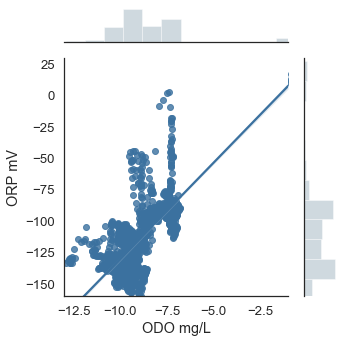

In [93]:
sns.set(style='white', font_scale=1.2)
g = sns.JointGrid(data=df2, x='ODO mg/L', y='ORP mV', xlim=(-13, -1), ylim=(-160, 30), height=5)
g = g.plot_joint(sns.regplot, color="xkcd:muted blue")
g = g.plot_marginals(sns.distplot, kde=False, bins=12, color="xkcd:bluey grey")
plt.tight_layout()

In [94]:
# Calculate the pairwise Spearman correlation
corr2 = pg.pairwise_corr(df2, columns=['ODO mg/L', 'Temp C', 'SpCond µS/cm', 'Turbidity NTU', 'pH', 'ORP mV', 'Water Added'], method='spearman')
# Sort the correlation by p-values and display the first rows
corr2.sort_values(by=['p-unc'])[['X', 'Y', 'n', 'r', 'p-unc']].head()

,X,Y,n,r,p-unc
4,ODO mg/L,ORP mV,1663,0.730,2.107584e-276
18,pH,ORP mV,1663,-0.456,2.588542e-86
20,ORP mV,Water Added,1663,0.438,4.260861e-79
5,ODO mg/L,Water Added,1663,0.435,1.084986e-77
17,Turbidity NTU,Water Added,1663,-0.431,2.221352e-76


In [95]:
df2.corr().round(2)

,ODO mg/L,Temp C,SpCond µS/cm,Turbidity NTU,pH,ORP mV,Water Added
ODO mg/L,1.00,-0.10,-0.85,-0.05,0.05,0.85,0.20
Temp C,-0.10,1.00,0.12,0.07,0.19,-0.08,-0.24
SpCond µS/cm,-0.85,0.12,1.00,-0.01,-0.25,-0.70,-0.05
Turbidity NTU,-0.05,0.07,-0.01,1.00,0.07,-0.15,-0.29
pH,0.05,0.19,-0.25,0.07,1.00,-0.13,-0.20
ORP mV,0.85,-0.08,-0.70,-0.15,-0.13,1.00,0.29
Water Added,0.20,-0.24,-0.05,-0.29,-0.20,0.29,1.00


Text(0.5, 1, 'Correlation matrix Drainage Section 2')

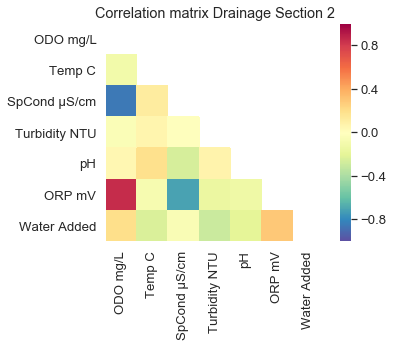

In [96]:
corrs2 = df2.corr()
mask = np.zeros_like(corrs2)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corrs2, cmap='Spectral_r', mask=mask, square=True, vmin=-1, vmax=1)
plt.title('Correlation matrix Drainage Section 2')

In [97]:
# Calculate the pairwise Spearman correlation
corr3 = pg.pairwise_corr(df3, columns=['ODO mg/L', 'Temp C', 'SpCond µS/cm', 'Turbidity NTU', 'pH', 'ORP mV', 'Water Added'], method='spearman')
# Sort the correlation by p-values and display the first rows
corr3.sort_values(by=['p-unc'])[['X', 'Y', 'n', 'r', 'p-unc']].head()

,X,Y,n,r,p-unc
1,ODO mg/L,SpCond µS/cm,1649,-0.949,0.000000e+00
20,ORP mV,Water Added,1649,-0.562,3.201050e-138
17,Turbidity NTU,Water Added,1649,0.478,1.011822e-94
13,SpCond µS/cm,ORP mV,1649,0.474,3.082970e-93
4,ODO mg/L,ORP mV,1649,-0.462,6.040968e-88


In [98]:
pg.corr(x=df3['SpCond µS/cm'], y=df3['ODO mg/L'])

,n,r,CI95%,r2,adj_r2,p-val,BF10,power
pearson,1649,-0.959,"[-0.96, -0.95]",0.919,0.919,0.0,inf,1.0


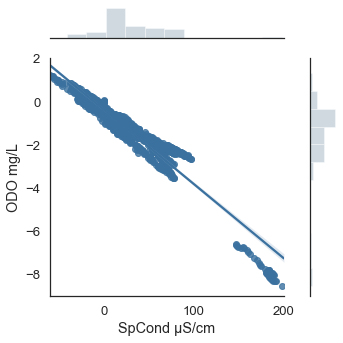

In [99]:
sns.set(style='white', font_scale=1.2)
g = sns.JointGrid(data=df3, x='SpCond µS/cm', y='ODO mg/L', xlim=(-60, 200), ylim=(-9, 2), height=5)
g = g.plot_joint(sns.regplot, color="xkcd:muted blue")
g = g.plot_marginals(sns.distplot, kde=False, bins=12, color="xkcd:bluey grey")
plt.tight_layout()

In [100]:
df3.corr().round(2)

,ODO mg/L,Temp C,SpCond µS/cm,Turbidity NTU,pH,ORP mV,Water Added
ODO mg/L,1.00,-0.01,-0.96,0.20,0.05,-0.18,0.19
Temp C,-0.01,1.00,-0.04,0.11,-0.28,0.00,0.27
SpCond µS/cm,-0.96,-0.04,1.00,-0.27,0.05,0.29,-0.28
Turbidity NTU,0.20,0.11,-0.27,1.00,0.02,-0.37,0.46
pH,0.05,-0.28,0.05,0.02,1.00,-0.24,0.12
ORP mV,-0.18,0.00,0.29,-0.37,-0.24,1.00,-0.63
Water Added,0.19,0.27,-0.28,0.46,0.12,-0.63,1.00


Text(0.5, 1, 'Correlation matrix Drainage Section 3')

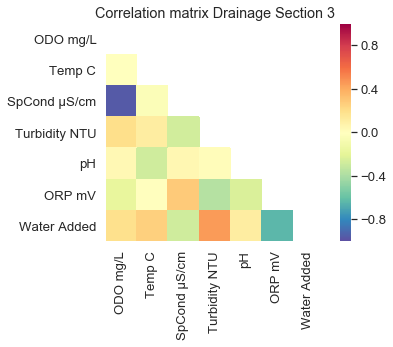

In [101]:
corrs3 = df3.corr()
mask = np.zeros_like(corrs3)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corrs3, cmap='Spectral_r', mask=mask, square=True, vmin=-1, vmax=1)
plt.title('Correlation matrix Drainage Section 3')

## Opening of the source data at https://doi.org/10.6084/m9.figshare.9786212


In [102]:
webbrowser.open('https://doi.org/10.6084/m9.figshare.9786212', new=1)

True